### Imports

In [2]:
### Import
import brainpy as bp
import brainpy.math as bm
import numpy as np 
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt
bm.set_platform('gpu')

### Setup 3 periods

In [3]:
pre_stimulus_period = 100.  # time before the external simuli are given
stimulus_period = 1000.  # time within which the external simuli are given
delay_period = 500.  # time after the external simuli are removed
total_period = pre_stimulus_period + stimulus_period + delay_period

In [4]:
class Tool:
  def __init__(self, pre_stimulus_period=100., stimulus_period=1000., delay_period=500.):
    self.pre_stimulus_period = pre_stimulus_period
    self.stimulus_period = stimulus_period
    self.delay_period = delay_period
    self.freq_variance = 10.
    self.freq_interval = 50.
    self.total_period = pre_stimulus_period + stimulus_period + delay_period

  def generate_freqs(self, mean):
    # stimulus period
    n_stim = int(self.stimulus_period / self.freq_interval)
    n_interval = int(self.freq_interval / bm.get_dt())
    freqs_stim = np.random.normal(mean, self.freq_variance, (n_stim, 1))
    freqs_stim = np.tile(freqs_stim, (1, n_interval)).flatten()
    # pre stimulus period
    freqs_pre = np.zeros(int(self.pre_stimulus_period / bm.get_dt()))
    # post stimulus period
    freqs_delay = np.zeros(int(self.delay_period / bm.get_dt()))
    all_freqs = np.concatenate([freqs_pre, freqs_stim, freqs_delay], axis=0)
    return bm.asarray(all_freqs)

  def visualize_results(self, mon, IA_freqs, IB_freqs, t_start=0., title=None):
    fig, gs = bp.visualize.get_figure(4, 1, 3, 10)
    axes = [fig.add_subplot(gs[i, 0]) for i in range(4)]

    ax = axes[0]
    bp.visualize.raster_plot(mon['ts'], mon['A.spike'], markersize=1, ax=ax)
    if title: ax.set_title(title)
    ax.set_ylabel("Group A")
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')

    ax = axes[1]
    bp.visualize.raster_plot(mon['ts'], mon['B.spike'], markersize=1, ax=ax)
    ax.set_ylabel("Group B")
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')

    ax = axes[2]
    rateA = bp.measure.firing_rate(mon['A.spike'], width=10.)
    rateB = bp.measure.firing_rate(mon['B.spike'], width=10.)
    ax.plot(mon['ts'], rateA, label="Group A")
    ax.plot(mon['ts'], rateB, label="Group B")
    ax.set_ylabel('Population activity [Hz]')
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')
    ax.legend()

    ax = axes[3]
    ax.plot(mon['ts'], IA_freqs, label="group A")
    ax.plot(mon['ts'], IB_freqs, label="group B")
    ax.set_ylabel("Input activity [Hz]")
    ax.set_xlim(t_start, self.total_period + 1)
    ax.axvline(self.pre_stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period, linestyle='dashed')
    ax.axvline(self.pre_stimulus_period + self.stimulus_period + self.delay_period, linestyle='dashed')
    ax.legend()
    ax.set_xlabel("Time [ms]")

    plt.show()

In [5]:
class ExpSyn(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max, tau, E):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.Expon.desc(post.num, tau=tau)
    out = bp.dyn.COBA.desc(E=E)
    self.proj = bp.dyn.FullProjAlignPostMg(
      pre=pre, delay=delay, comm=comm,
      syn=syn, out=out, post=post
    )


class NMDA(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.NMDA.desc(pre.num, a=0.5, tau_decay=100., tau_rise=2.)
    out = bp.dyn.MgBlock(E=0., cc_Mg=1.0)
    self.proj = bp.dyn.FullProjAlignPreDSMg(
      pre=pre, delay=delay, syn=syn,
      comm=comm, out=out, post=post
    )

In [8]:
class DecisionMakingNet(bp.DynSysGroup):
  def __init__(self, scale=1., f=0.15):
    super().__init__()
    # 网络中各组神经元的数目
    num_exc = int(1600 * scale)
    num_I, num_A, num_B = int(400 * scale), int(f * num_exc), int(f * num_exc)
    num_N = num_exc - num_A - num_B
    self.num_A, self.num_B, self.num_N, self.num_I = num_A, num_B, num_N, num_I

    poisson_freq = 2400.  # Hz
    w_pos = 1.7
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_ext2E_AMPA = 2.1  # nS
    g_ext2I_AMPA = 1.62  # nS
    g_E2E_AMPA = 0.05 / scale  # nS
    g_E2I_AMPA = 0.04 / scale  # nS
    g_E2E_NMDA = 0.165 / scale  # nS
    g_E2I_NMDA = 0.13 / scale  # nS
    g_I2E_GABAa = 1.3 / scale  # nS
    g_I2I_GABAa = 1.0 / scale  # nS

    neu_par = dict(V_rest=-70., V_reset=-55., V_th=-50., V_initializer=bp.init.OneInit(-70.))

    # E neurons/pyramid neurons
    self.A = bp.dyn.LifRef(num_A, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.B = bp.dyn.LifRef(num_B, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.N = bp.dyn.LifRef(num_N, tau=20., R=0.04, tau_ref=2., **neu_par)

    # I neurons/interneurons
    self.I = bp.dyn.LifRef(num_I, tau=10., R=0.05, tau_ref=1., **neu_par)

    # poisson stimulus  # 'freqs' as bm.Variable
    self.IA = bp.dyn.PoissonGroup(num_A, freqs=bm.Variable(bm.zeros(1)))
    self.IB = bp.dyn.PoissonGroup(num_B, freqs=bm.Variable(bm.zeros(1)))

    # noise neurons
    self.noise_B = bp.dyn.PoissonGroup(num_B, freqs=poisson_freq)
    self.noise_A = bp.dyn.PoissonGroup(num_A, freqs=poisson_freq)
    self.noise_N = bp.dyn.PoissonGroup(num_N, freqs=poisson_freq)
    self.noise_I = bp.dyn.PoissonGroup(num_I, freqs=poisson_freq)

    # define external inputs
    self.IA2A = ExpSyn(self.IA, self.A, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.IB2B = ExpSyn(self.IB, self.B, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)

    # define AMPA projections from N
    self.N2B_AMPA = ExpSyn(self.N, self.B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.N2A_AMPA = ExpSyn(self.N, self.A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.N2N_AMPA = ExpSyn(self.N, self.N, 'all2all', 0.5, g_E2E_AMPA, tau=2., E=0.)
    self.N2I_AMPA = ExpSyn(self.N, self.I, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # define NMDA projections from N
    self.N2B_NMDA = NMDA(self.N, self.B, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.N2A_NMDA = NMDA(self.N, self.A, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.N2N_NMDA = NMDA(self.N, self.N, 'all2all', 0.5, g_E2E_NMDA)
    self.N2I_NMDA = NMDA(self.N, self.I, 'all2all', 0.5, g_E2I_NMDA)

    # define AMPA projections from B
    self.B2B_AMPA = ExpSyn(self.B, self.B, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.B2A_AMPA = ExpSyn(self.B, self.A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.B2N_AMPA = ExpSyn(self.B, self.N, 'all2all', 0.5, g_E2E_AMPA, tau=2., E=0.)
    self.B2I_AMPA = ExpSyn(self.B, self.I, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # define NMDA projections from B
    self.B2B_NMDA = NMDA(self.B, self.B, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.B2A_NMDA = NMDA(self.B, self.A, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.B2N_NMDA = NMDA(self.B, self.N, 'all2all', 0.5, g_E2E_NMDA)
    self.B2I_NMDA = NMDA(self.B, self.I, 'all2all', 0.5, g_E2I_NMDA)

    # define AMPA projections from A
    self.A2B_AMPA = ExpSyn(self.A, self.B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.A2A_AMPA = ExpSyn(self.A, self.A, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.A2N_AMPA = ExpSyn(self.A, self.N, 'all2all', 0.5, g_E2E_AMPA, tau=2., E=0.)
    self.A2I_AMPA = ExpSyn(self.A, self.I, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # define NMDA projections from A
    self.A2B_NMDA = NMDA(self.A, self.B, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.A2A_NMDA = NMDA(self.A, self.A, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.A2N_NMDA = NMDA(self.A, self.N, 'all2all', 0.5, g_E2E_NMDA)
    self.A2I_NMDA = NMDA(self.A, self.I, 'all2all', 0.5, g_E2I_NMDA)

    # define I->E/I conn
    self.I2B = ExpSyn(self.I, self.B, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.I2A = ExpSyn(self.I, self.A, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.I2N = ExpSyn(self.I, self.N, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.I2I = ExpSyn(self.I, self.I, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)

    # define external projections
    self.noise2B = ExpSyn(self.noise_B, self.B, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2A = ExpSyn(self.noise_A, self.A, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2N = ExpSyn(self.noise_N, self.N, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2I = ExpSyn(self.noise_I, self.I, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)

### Running the simulation

In [9]:
tool = Tool()
net = DecisionMakingNet()

In [10]:
mu0 = 40.
coherence = 25.6
IA_freqs = tool.generate_freqs(mu0 + mu0 / 100. * coherence)
IB_freqs = tool.generate_freqs(mu0 - mu0 / 100. * coherence)

def give_input():
    i = bp.share['i']
    net.IA.freqs[0] = IA_freqs[i]
    net.IB.freqs[0] = IB_freqs[i]

In [11]:
runner = bp.DSRunner(net, inputs=give_input, monitors=['A.spike', 'B.spike'])
runner.run(tool.total_period)

Running for 16,000 iterations: 100%|██████████| 16000/16000 [00:00<00:00, 26772.74it/s]


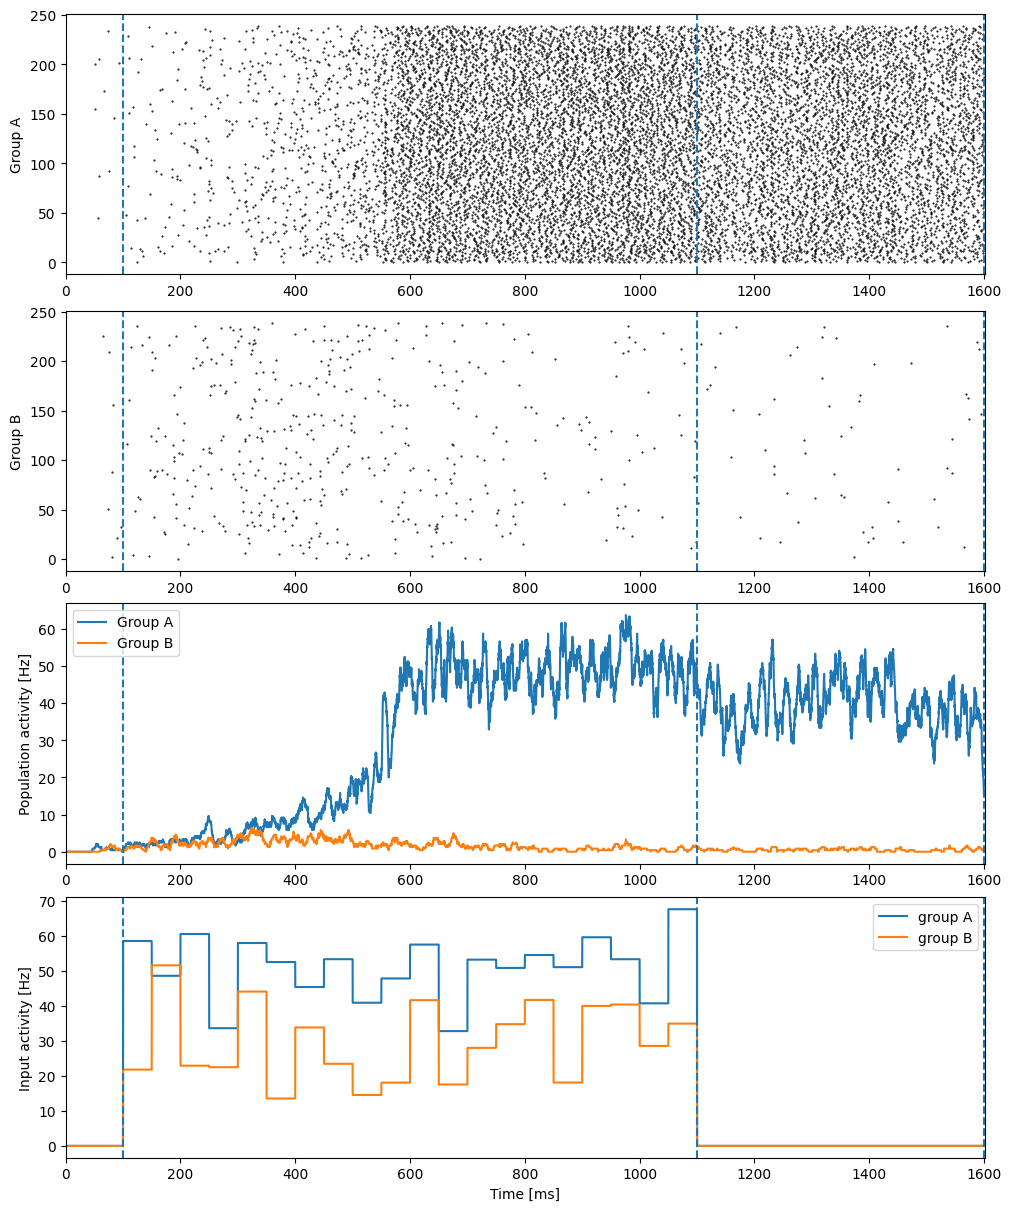

In [12]:
tool.visualize_results(runner.mon, IA_freqs, IB_freqs)